# 使用K-means聚类算法对 MNIST 手写数字进行分类预测

手写、单位数编号的MNIST数据集 — 此数据集提供 60,000 个手写、单位数编号的映像示例以及包含 10,000 个映像的测试数据集。

使用 Amazon SageMaker 提供的 k-means 算法。K-means 是一种集群算法。在模型训练期间，该算法将手写编号的示例数据分为 10 个集群 (从 0 到 9，每个编号各一个集群)。有关该算法的更多信息，请参阅K-Means 算法。

在本练习中，将执行以下操作：
1 将 MNIST 数据集下载到您的 Amazon SageMaker 笔记本实例，然后查看数据并进行预处理。
2 启动一个 Amazon SageMaker 训练任务。
3 在 Amazon SageMaker 中部署模型。
4 通过将推理请求发送至模型的终端节点来验证模型。请发送手写单位数编号的映像。模型将返回映像所属的集群的编号 (0 到 9)。

对于模型训练、部署和验证，使用以下选项：
Amazon SageMaker 提供的高级 Python 库，该高级库提取了多个实施的详细信息，并且易于使用。此练习提供了分别使用这两种库的代码示例。如果您是 Amazon SageMaker 的新用户，建议使用高级 Python 库。有关更多信息，请参阅 Amazon SageMaker 编程模型 。

In [1]:
# 获取Sagemker的执行角色，并定义用于训练的S3存储桶名称
from sagemaker import get_execution_role

role = get_execution_role()
bucket='your_bucket'

下载mnist的数据集合到notebook实例本地，分别导入训练集、验证集、测试集

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Download the mnist dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 860 ms, sys: 312 ms, total: 1.17 s
Wall time: 4.06 s


定义一个绘画函数show_digit，用来将mnist中的数字画出来，在这里将训练集中第30张图片画出来

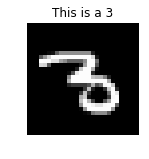

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

将mnist数据集从 numpy.array 格式转换为 RecordIO protobuf 格式，并上传到指定的S3存储桶中，对于 Amazon SageMaker 提供的所有算法，RecordIO protobuf 格式更有效。

In [4]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://421710401846-sagemaker-us-west-2/kmeans_lowlevel_example/data
CPU times: user 9.15 s, sys: 396 ms, total: 9.55 s
Wall time: 10.6 s


为了训练模型，Amazon SageMaker 需要提供以下信息：

训练算法 — 指定包含训练代码的 Docker 镜像的注册表路径。在以下示例中，当使用高级 Python 库，无需明确指定此路径。sagemaker.amazon.kmeans.KMeans 对象知道该路径。

K-Means算法的超级参数 — 指定K-Means算法的超级参数以影响模型的最终质量。k=10，代表把mnist分成10类，0～9。

输入和输出配置 — 提供用于存储训练数据且 Amazon SageMaker 用于保存模型训练结果 (模型项目) 的 S3 存储桶。

In [20]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.p3.2xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://421710401846-sagemaker-us-west-2/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://421710401846-sagemaker-us-west-2/kmeans_example/output


调用 fit 方法启动模型训练。

In [21]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-09-04-06-18-08-474


...................
Docker entrypoint called with argument(s): train
[09/04/2018 06:21:02 INFO 139753314162496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[09/04/2018 06:21:02 INFO 139753314162496] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'k': u'10', u'force_dense': u'True'}
[09/04/2018 06:21:02 INFO 139753314162496] Final configuration: {u'k'


Billable seconds: 109
CPU times: user 7.97 s, sys: 412 ms, total: 8.38 s
Wall time: 3min 51s


调用 deploy 方法部署模型。

In [15]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-09-04-06-05-39-649
INFO:sagemaker:Creating endpoint with name kmeans-2018-09-04-05-56-10-348


--------------------------------------------------------------------------!CPU times: user 332 ms, sys: 12 ms, total: 344 ms
Wall time: 6min 14s


获取关于 valid_set 测试数据集中第 30 张手写编号图像的推理。响应表明输入映像属于集群X。它还显示了该集群的平均平方距离。
#### 注意
在 k-means 实施中，集群编号与其所代表的数字不一致。例如，该算法可能将手写编号 3 的图像分到集群 0 中，将编号 4 的图像分到集群 9 中。

In [16]:

result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.799480438232422
    }
  }
}
]


获取 valid_set 验证集中前100 张图像的推理结果。

In [17]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 211 ms


将推理的结果划分相似图像的集群。以下视图显示了模型返回的10个集群：




Cluster 0:


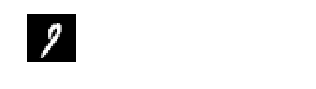




Cluster 1:


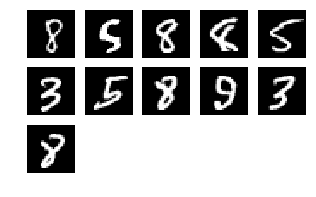




Cluster 2:


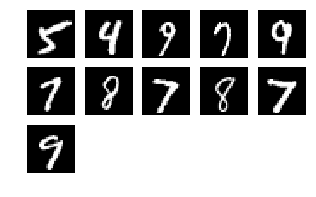




Cluster 3:


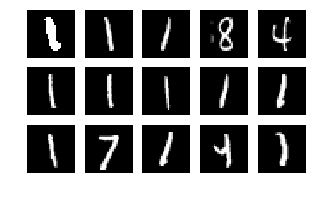




Cluster 4:


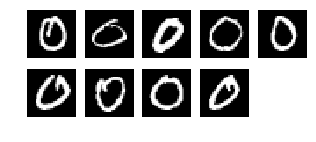




Cluster 5:


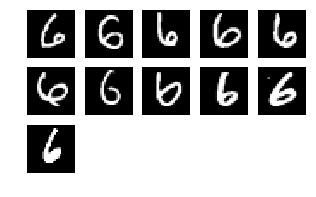




Cluster 6:


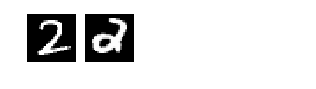




Cluster 7:


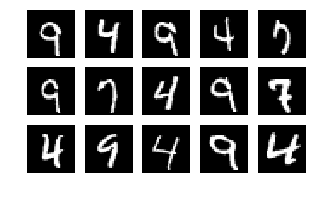




Cluster 8:


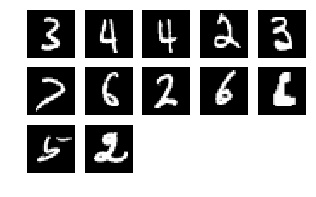




Cluster 9:


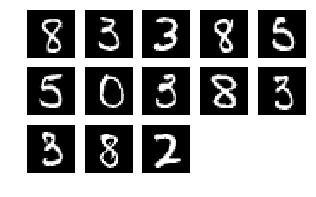

In [18]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()